In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
pet = pd.read_csv('seattle_pet_licenses.csv', parse_dates=True)
pet.head()

,animal_s_name,license_issue_date,license_number,primary_breed,secondary_breed,species,zip_code
0,Ozzy,2005-03-29T00:00:00.000,130651.0,"Dachshund, Standard Smooth Haired",NaN,Dog,98104
1,Jack,2009-12-23T00:00:00.000,898148.0,"Schnauzer, Miniature","Terrier, Rat",Dog,98107
2,Ginger,2006-01-20T00:00:00.000,29654.0,"Retriever, Golden","Retriever, Labrador",Dog,98117
3,Pepper,2006-02-07T00:00:00.000,75432.0,Manx,Mix,Cat,98103
4,Addy,2006-08-04T00:00:00.000,729899.0,"Retriever, Golden",NaN,Dog,98105


In [4]:
pet.count()

animal_s_name         64685
license_issue_date    66042
license_number        43885
primary_breed         66042
secondary_breed       22538
species               66042
zip_code              65884
dtype: int64

In [5]:
pet.shape

(66042, 7)

In [6]:
pet.license_issue_date = pd.to_datetime(pet.license_issue_date)

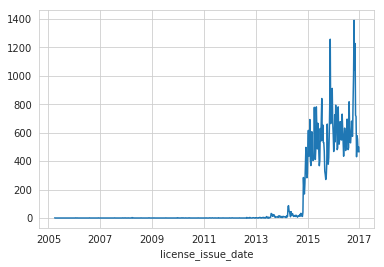

In [7]:
adocoes = pet.set_index('license_issue_date').sort_index().resample('7D').count()['species']
sns.lineplot(adocoes.index, adocoes.values)

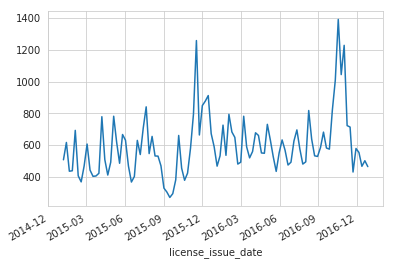

In [9]:
adocoes2015 = adocoes['2015':'2016']
fig, ax = plt.subplots()
sns.lineplot(adocoes2015.index, adocoes2015.values, ax=ax)
fig.autofmt_xdate()

In [10]:
forecast_df = pet.set_index('license_issue_date').sort_index()['2015':'2016'].resample('7D').count()['species'].to_frame()
forecast_df.columns = ['#adocoes']
forecast_df.index.name = 'semana'
forecast_df.head()

,#adocoes
semana,
2015-01-02,433
2015-01-09,741
2015-01-16,412
2015-01-23,399
2015-01-30,686


In [11]:
forecast_df['#adocoes t-1'] = forecast_df['#adocoes'].shift(1)
forecast_df['#adocoes t-2'] = forecast_df['#adocoes'].shift(2)
forecast_df['#adocoes t-3'] = forecast_df['#adocoes'].shift(3)
forecast_df.head()

,#adocoes,#adocoes t-1,#adocoes t-2,#adocoes t-3
semana,,,,
2015-01-02,433,NaN,NaN,NaN
2015-01-09,741,433.0,NaN,NaN
2015-01-16,412,741.0,433.0,NaN
2015-01-23,399,412.0,741.0,433.0
2015-01-30,686,399.0,412.0,741.0


In [12]:
forecast_df = forecast_df.dropna()
x = forecast_df.drop(columns=['#adocoes']).values
y = forecast_df['#adocoes'].values

In [13]:
from sklearn.neural_network import MLPRegressor

In [14]:
x.shape

(102, 3)

In [15]:
xtrain = x[:-10]
xtest = x[-10:]
np.array_equal(np.vstack([xtrain, xtest]), x)

True

In [16]:
ytrain = y[:-10]
ytest = y[-10:]

In [17]:
model = MLPRegressor()
model.fit(xtrain, ytrain)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [18]:
model.predict(xtest)

array([1026.55111147, 1407.25045687, 1082.08344219, 1021.36777203,
        680.24548837,  654.7917934 ,  525.95624311,  555.57345582,
        561.79138804,  542.37297713])

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
mean_absolute_error(y_true=ytest, y_pred=model.predict(xtest))

274.4969419272634

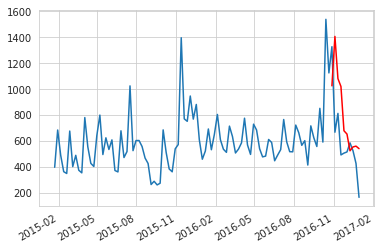

In [21]:
a = forecast_df.index
fig, ax = plt.subplots()
plt.plot(a, y)
plt.plot(a[-10:], model.predict(xtest), c='r')
fig.autofmt_xdate()

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [25]:
y_b = (forecast_df['#adocoes'].shift(1) > y).values

In [26]:
y_b.shape

(102,)

In [27]:
xtrain.shape

(92, 3)

In [28]:
model = MLPClassifier()
model.fit(xtrain, y_b[:-10])
pred = model.predict(xtest)
accuracy_score(y_true=y_b[-10:], y_pred=pred)

0.6